RELOAD maen file: ./ped/mean_Run01403 sigma file: ./ped/sigma_Run01403
/run01402.mid.gz
/run01402.mid.gz
Saw a special event


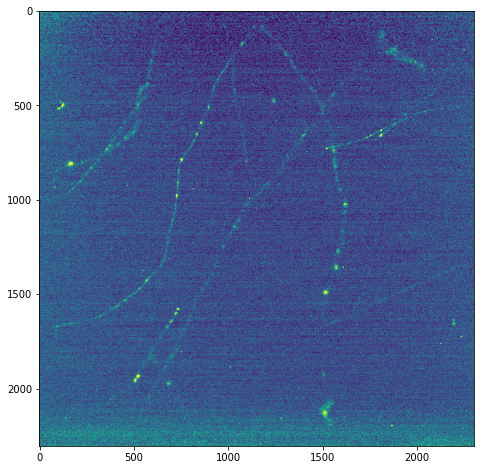

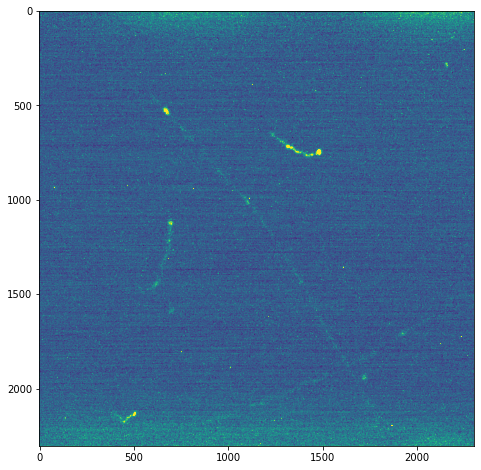

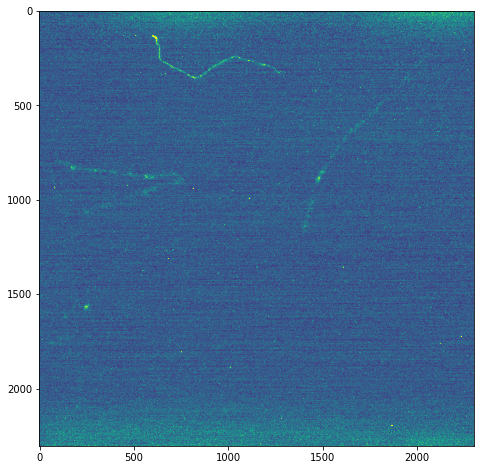

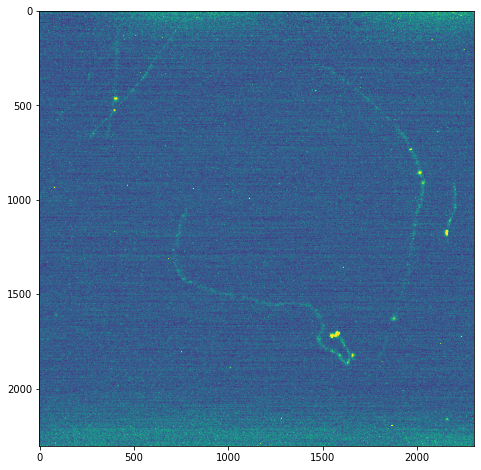

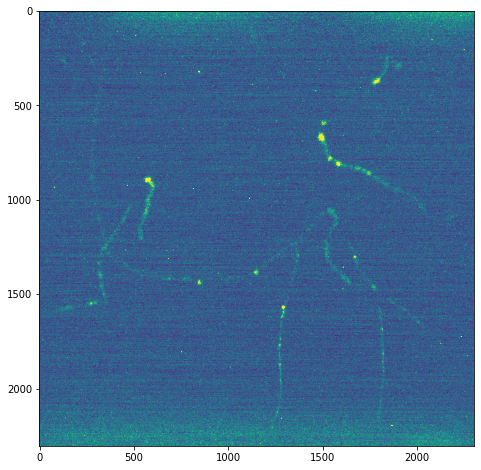

KeyboardInterrupt: 

In [2]:
import midas.file_reader
from datetime import datetime
import numpy as np
from matplotlib import pyplot as plt
import cygno as cy
class myError(Exception):
    pass

def ped_(run, ped_path='./ped/', data_path='/jupyter-workspace/cloud-storage/cygno-data/', 
         tag = 'STD', cloud=False, min_image_to_read = 0, 
         max_image_to_read = 0, verbose=False):
        
    import numpy as np
    import os
    # funzione per fare i piedistalli se gia' non esistino nella diretory
    data_path = data_path+tag+'/'
    fileoutm = (ped_path+"mean_Run{:05d}".format(run))
    fileouts = (ped_path+"sigma_Run{:05d}".format(run))

    if os.path.exists(fileoutm+".npy") and os.path.exists(fileouts+".npy"): 
        # i file gia' esistono
        m_image = np.load(fileoutm+".npy")
        s_image = np.load(fileouts+".npy")
        print("RELOAD maen file: {:s} sigma file: {:s}".format(fileoutm, fileouts))
        return m_image, s_image
    else:
        # i file non esistono crea il file delle medie e delle sigma per ogni pixel dell'immagine
        if verbose: print (">>> Pedestal Maker! <<<")
        try:
            mfile = cy.open_mid(run=run, path=data_path, cloud=cloud, tag=tag, verbose=verbose)
        except:
            print (data_path)
            raise myError("openRunError: "+str(run))
        if max_image_to_read == 0:
            max_image_to_read=10000000000000
        print ("WARNING: pdestal from %d to %d" % (min_image_to_read, max_image_to_read))
        init = True
        iTr  = min_image_to_read
        for event in mfile:
            if iTr<max_image_to_read:
                if bank_name=='CAM0': # CAM image
                    image, sx, sy = cy.daq_cam2array(bank)
                    if init:
                        m_image = np.zeros((sx, sy), dtype=np.float64)
                        s_image = np.zeros((sx, sy), dtype=np.float64)
                        init = False
                        n0 = 0
                    m_image += image
                    s_image += image**2 
                    if verbose or n0 % 10==0:  
                        print (" processing imege %d " % (iTr))
                    n0  += 1
                    iTr += 1 
                    m_image = m_image/n0 
                    s_image = np.sqrt((s_image - m_image**2 * n0) / (n0 - 1))
            else:
                break
       
        ###### print Info and Save OutPut ######################################
        print("WRITING ...")
        np.save(fileoutm+".npy", m_image)
        np.save(fileouts+".npy", s_image)
        print("DONE OUTPUT maen file: {:s} sigma file: {:s}".format(fileoutm, fileouts))
        return m_image, s_image  

m_image, s_image = ped_(run=1403, ped_path='./ped/', tag = 'STD', 
     cloud=False, min_image_to_read = 1, max_image_to_read = 101, verbose=False)
mfile = cy.open_mid(run=1402, path='/jupyter-workspace/cloud-storage/cygno-data/STD/', 
                        cloud=False, tag='STD', verbose=True)
# number of track to show
nTr = 4
iTr = 0

for event in mfile:
    if iTr<=nTr:
        if event.header.is_midas_internal_event():
            print("Saw a special event")
            continue

        bank_names = ", ".join(b.name for b in event.banks.values())
  
        for bank_name, bank in event.banks.items():
            if bank_name=='CAM0': # CAM image
                image, _, _ = cy.daq_cam2array(bank)

                plt.figure(figsize=(8,8))
                plt.imshow(image-m_image, vmin=95, vmax=110)
                plt.show()
                iTr +=1 
    else:
        break